In [2]:
import numpy as np
import tensorflow as tf

class Layer:
    """
    Layer is base class of all layers
    """
    def __init__(self):
        self.input = None
        self.output = None

    def forward_prop(self, input_data):
        """forwardは順伝播の処理を表す。子クラスは中身を実装しないといけない"""
        raise NotImplementedError

    def backward_prop(self, output_gradient, learning_rate=None):
        """backwardは逆伝播の処理を表す。子クラスは中身を実装しないといけない"""
        raise NotImplementedError

    # Backward compatibility
    def forward(self, input_data):
        return self.forward_prop(input_data)

    def backward(self, output_gradient, learning_rate=None):
        return self.backward_prop(output_gradient, learning_rate)


Matplotlib is building the font cache; this may take a moment.


## 全結合層(ReLU関数)

In [3]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward_prop(self, input_data):
        self.input = input_data
        return np.maximum(0, self.input)

    def backward_prop(self, output_gradient, learning_rate=None):
        """順伝播の入力が０より大きかった場所だけ勾配をそのまま後ろに流す"""
        mask = self.input > 0
        return output_gradient * mask


## （Max）プーリング層
- 入力を小さな領域（プール）に区切り、各領域の最大値だけを取り出して出力を小さくする
- `backward`: 順伝播の時に最大値だった場所（選択された場所）にだけ勾配を流す。選ばれなかった場所の勾配は０とする

In [4]:
class MaxPooling(Layer):
    def __init__(self, pool_size):
        super().__init__()
        self.pool_size = pool_size

    def forward_prop(self, input_data):
        # backwardのために入力を記憶しておく
        self.input = input_data

        depth, height, width = self.input.shape
        ph, pw = self.pool_size, self.pool_size
        output_height = height // ph
        output_width = width // pw

        output = np.zeros((depth, output_height, output_width))

        # 位置を保存してbackwardで使う
        self.argmax_indices = {}

        for d_i in range(depth):
            for h_i in range(output_height):
                for w_i in range(output_width):
                    h_start, h_end = h_i*ph, (h_i + 1)*ph
                    w_start, w_end = w_i*pw, (w_i + 1)*pw
                    window = self.input[d_i, h_start:h_end, w_start:w_end]
                    max_index = np.unravel_index(np.argmax(window), window.shape)
                    output[d_i, h_i, w_i] = window[max_index]
                    self.argmax_indices[(d_i, h_i, w_i)] = (h_start + max_index[0], w_start + max_index[1])

        return output

    def backward_prop(self, output_gradient, learning_rate=None):
        input_gradient = np.zeros_like(self.input)

        depth, height, width = self.input.shape
        ph, pw = self.pool_size, self.pool_size
        output_height = height // ph
        output_width = width // pw
        
        for d_i in range(depth):
            for h_i in range(output_height):
                for w_i in range(output_width):
                    h_max, w_max = self.argmax_indices[(d_i, h_i, w_i)]
                    input_gradient[d_i, h_max, w_max] += output_gradient[d_i, h_i, w_i]

        return input_gradient


In [5]:

class ConvolutionalLayer(Layer):
    def __init__(self, kernel_num, kernel_size, stride=1, use_bias=True):
        super().__init__()

        self.no_of_kernels = kernel_num
        self.kernel_size = kernel_size
        self.stride = stride
        self.use_bias = use_bias # true or false
        scaling_factor = self.kernel_size ** 2
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / scaling_factor
        self.bias = np.zeros(kernel_num) if use_bias else None

    def forward_prop(self, input_data):
        # input is 2D (H, W)
        self.input = input_data
        input_h, input_w = self.input.shape
        out_h = (input_h - self.kernel_size) // self.stride + 1
        out_w = (input_w - self.kernel_size) // self.stride + 1
        conv_output = np.zeros((self.no_of_kernels, out_h, out_w))

        for h in range(0, input_h - self.kernel_size + 1, self.stride):
            for w in range(0, input_w - self.kernel_size + 1, self.stride):
                sec = self.input[h:h + self.kernel_size, w:w + self.kernel_size]
                h_i = h // self.stride
                w_i = w // self.stride
                # per-filter convolution
                conv_output[:, h_i, w_i] = np.tensordot(self.kernels, sec, axes=((1, 2), (0, 1)))

        if self.use_bias:
            conv_output += self.bias[:, np.newaxis, np.newaxis]

        return conv_output

    def backward_prop(self, output_gradient, learning_rate=0.01):
        # output_gradient shape: (F, out_h, out_w)
        input_h, input_w = self.input.shape
        out_h = output_gradient.shape[1]
        out_w = output_gradient.shape[2]

        dL_dk = np.zeros_like(self.kernels)
        dL_db = np.zeros_like(self.bias) if self.use_bias else None
        dL_dinput = np.zeros_like(self.input)

        for h_i in range(out_h):
            for w_i in range(out_w):
                h = h_i * self.stride
                w = w_i * self.stride
                sec = self.input[h:h + self.kernel_size, w:w + self.kernel_size]
                # kernel gradients
                dL_dk += output_gradient[:, h_i, w_i][:, np.newaxis, np.newaxis] * sec
                # input gradients
                dL_dinput[h:h + self.kernel_size, w:w + self.kernel_size] += np.sum(
                    self.kernels * output_gradient[:, h_i, w_i][:, np.newaxis, np.newaxis], axis=0
                )
                if self.use_bias:
                    dL_db += output_gradient[:, h_i, w_i]

        # update
        self.kernels -= learning_rate * dL_dk
        if self.use_bias:
            self.bias -= learning_rate * dL_db

        return dL_dinput


## 全結合層(Softmax関数)


In [6]:
class FullyCon_SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units) / input_units
        self.bias = np.zeros(output_units)
        self.output = None
        self.softmax_output = None

    def _dense_layer(self, image):
        self.original_shape = image.shape
        image_flattened = image.flatten()
        self.flattened_input = image_flattened
        dense_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = dense_output
        return dense_output

    def _softmax_out(self, dense_out):
        shifted = dense_out - np.max(dense_out)
        exp_vals = np.exp(shifted)
        softmax_output = exp_vals / np.sum(exp_vals)
        return softmax_output

    def forward_prop(self, image):
        dense_out = self._dense_layer(image)
        softmax_output = self._softmax_out(dense_out)
        self.softmax_output = softmax_output
        return softmax_output

    def backward_prop(self, dL_dy, lr):
        # dL_dy: gradient w.r.t softmax output
        y = self.softmax_output
        J = np.diag(y) - np.outer(y, y)
        dE_dZ = J @ dL_dy

        dZ_dw = self.flattened_input  # (N,)
        dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]  # (N, C)
        dE_db = dE_dZ  # (C,)
        dE_dX = self.weight @ dE_dZ  # (N,)

        self.weight -= lr * dE_dw
        self.bias -= lr * dE_db

        return dE_dX.reshape(self.original_shape)


In [7]:
class Train_Pred_Model:
    def __init__(self, epochs=10, imgs=None, labels=None, layers=None, isMnist=True, train=True):
        self.isMnist = isMnist
        self.imgs = imgs
        self.labels = labels
        self.layers = layers
        self.epochs = epochs

        if train:
            if self.isMnist:
                self.layers = self._mnist_exec()
            else:
                self.layers = self._normal_exec()

    def _mnist_exec(self):
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
        X_train = X_train[:5000]
        y_train = y_train[:5000]

        layers = [
            ConvolutionalLayer(16, 3),
            MaxPooling(2),
            FullyCon_SoftmaxLayer(13 * 13 * 16, 10),
        ]

        for epoch in range(self.epochs):
            print("Epoch {} ->".format(epoch + 1))

            permutation = np.random.permutation(len(X_train))
            X_train = X_train[permutation]
            y_train = y_train[permutation]

            loss = 0.0
            accuracy = 0
            for i, (image, label) in enumerate(zip(X_train, y_train)):
                if i % 100 == 0 and i > 0:
                    print(
                        "Step {}. For the last 100 steps: average loss {:.4f}, accuracy {}".format(
                            i, loss / 100, accuracy
                        )
                    )
                    loss = 0.0
                    accuracy = 0
                loss_1, accuracy_1 = self.train(image, label, layers)
                loss += loss_1
                accuracy += accuracy_1
        return layers

    def _normal_exec(self):
        for epoch in range(self.epochs):
            loss = 0.0
            accuracy = 0
            for i, (image, label) in enumerate(zip(self.imgs, self.labels)):
                if i % 100 == 0 and i > 0:
                    print(
                        "Step {}. For the last 100 steps: average loss {:.4f}, accuracy {}".format(
                            i, loss / 100, accuracy
                        )
                    )
                    loss = 0.0
                    accuracy = 0
                loss_1, accuracy_1 = self.train(image, label, self.layers)
                loss += loss_1
                accuracy += accuracy_1
            print(f"Epoch {epoch + 1}--> loss: {loss:.4f}  accuracy: {accuracy}")
        return self.layers

    def _forward(self, img, label, layers):
        output = img / 255.0
        for layer in layers:
            output = layer.forward_prop(output)
        loss = -np.log(output[label] + 1e-12)
        acc = 1 if np.argmax(output) == label else 0
        return output, loss, acc

    def _backprop(self, gradients, layers, lr=0.01):
        grad = gradients
        for layer in layers[::-1]:
            if isinstance(layer, (ConvolutionalLayer, FullyCon_SoftmaxLayer)):
                grad = layer.backward_prop(grad, lr)
            else:
                grad = layer.backward_prop(grad)
        return grad

    def train(self, img, label, layers, lr=0.05):
        output, loss, acc = self._forward(img, label, layers)
        gradient = np.zeros(10)
        gradient[label] = -1.0 / (output[label] + 1e-12)
        self._backprop(gradient, layers, lr)
        return loss, acc

    def predict(self, img, layers):
        output = img / 255.0
        for layer in layers:
            output = layer.forward_prop(output)
        return output


In [8]:
# Train and evaluate CNN on MNIST
import numpy as np
import tensorflow as tf

# Train
trainer = Train_Pred_Model(epochs=1, isMnist=True, train=True)

# Evaluate on test set (subset for speed)
(_, _), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
num_eval = 1000
X_eval = X_test[:num_eval]
y_eval = y_test[:num_eval]

correct = 0
for img, label in zip(X_eval, y_eval):
    output = trainer.predict(img, trainer.layers)
    pred = int(np.argmax(output))
    correct += int(pred == label)

acc = correct / num_eval
print(f"Test accuracy on {num_eval} samples: {acc:.4f}")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1 ->
Step 100. For the last 100 steps: average loss 1.7527, accuracy 44
Step 200. For the last 100 steps: average loss 1.2676, accuracy 61
Step 300. For the last 100 steps: average loss 0.9743, accuracy 70
Step 400. For the last 100 steps: average loss 0.7358, accuracy 80
Step 500. For the last 100 steps: average loss 0.6331, accuracy 83
Step 600. For the last 100 steps: average loss 0.6213, accuracy 81
Step 700. For the last 100 steps: average loss 0.7033, accuracy 80
Step 800. For the last 100 steps: average loss 0.8507, accuracy 79
Step 900. For the last 100 steps: average loss 0.6263, accuracy 87
Step 1000. For the last 100 steps: average loss 0.7027, accuracy 80
Step 1100. For the last 100 steps: average loss 0.5218, accuracy 84
Step 1200. For the last 100 steps: average loss 0.6364, accuracy 79
Step 1300. For the last 100 steps: average loss 0.6573, accuracy 86
Step 1400. For the last 100 steps: average loss 0.3556, accurac

Overall accuracy on 1000 samples: 0.8450


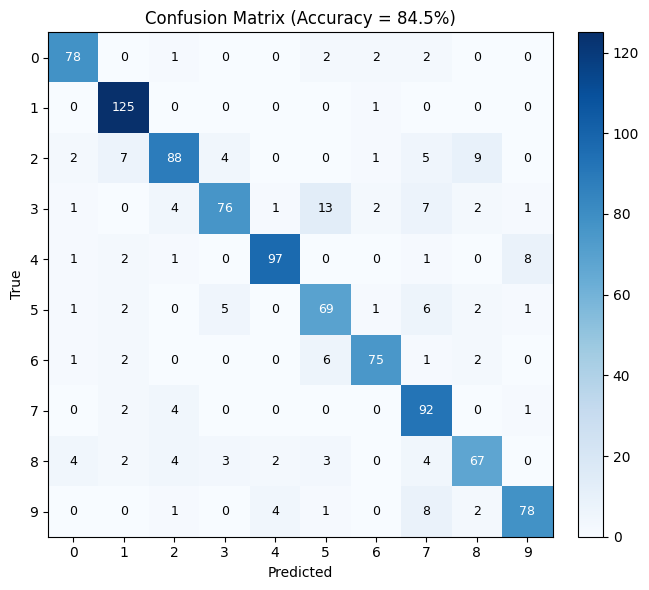

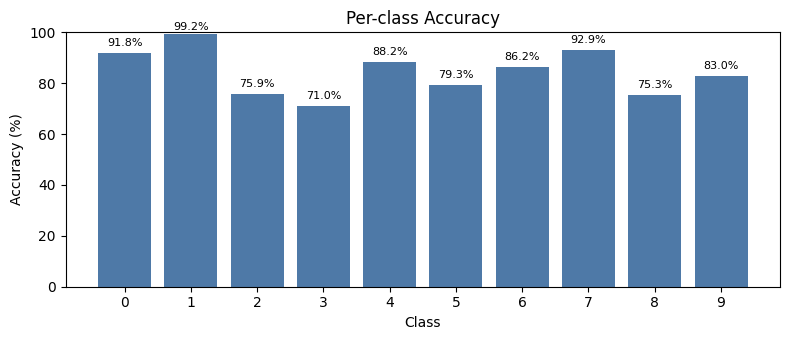

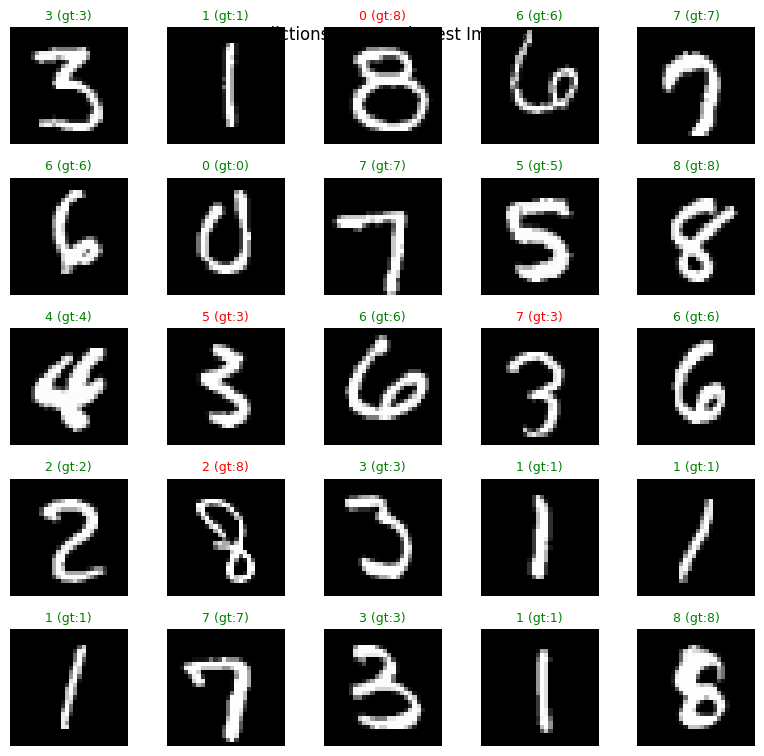

In [9]:
# Visualize CNN results: confusion matrix, per-class accuracy, and sample predictions
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure evaluation data exists
try:
    X_eval
    y_eval
    num_eval
except NameError:
    (_, _), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    num_eval = 1000
    X_eval = X_test[:num_eval]
    y_eval = y_test[:num_eval]

# Ensure trained model exists (fallback: create untrained model if missing)
try:
    trainer
except NameError:
    trainer = Train_Pred_Model(epochs=0, isMnist=True, train=True)

# Collect predictions
y_true = y_eval
y_pred = []
for img in X_eval:
    out = trainer.predict(img, trainer.layers)
    y_pred.append(int(np.argmax(out)))
y_pred = np.array(y_pred)

# Overall accuracy
acc = float(np.mean(y_pred == y_true))
print(f"Overall accuracy on {len(y_true)} samples: {acc:.4f}")

# Confusion matrix
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# Plot 1: Confusion matrix heatmap
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, cmap="Blues")
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_title(f"Confusion Matrix (Accuracy = {acc*100:.1f}%)")

# Annotate cells
thresh = cm.max() / 2 if cm.max() > 0 else 0.5
for i in range(num_classes):
    for j in range(num_classes):
        val = cm[i, j]
        ax.text(j, i, str(val), ha="center", va="center",
                color="white" if val > thresh else "black", fontsize=9)
plt.tight_layout()
plt.show()

# Plot 2: Per-class accuracy bar chart
support = cm.sum(axis=1)
corrects = np.diag(cm)
per_class_acc = np.divide(corrects, support, out=np.zeros_like(corrects, dtype=float), where=support != 0)

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.bar(np.arange(num_classes), per_class_acc * 100, color="#4e79a7")
ax.set_ylim(0, 100)
ax.set_xticks(range(num_classes))
ax.set_xlabel("Class")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Per-class Accuracy")
for i, v in enumerate(per_class_acc * 100):
    ax.text(i, min(v + 2, 100), f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# Plot 3: Sample predictions grid
n_show = 25
idxs = np.random.choice(len(X_eval), size=n_show, replace=False)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for ax, idx in zip(axes.ravel(), idxs):
    img = X_eval[idx]
    true = int(y_true[idx])
    pred = int(y_pred[idx])
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    color = "green" if pred == true else "red"
    ax.set_title(f"{pred} (gt:{true})", color=color, fontsize=9)
fig.suptitle("Predictions on Sample Test Images", y=0.92)
plt.tight_layout()
plt.show()
